In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt
import numpy as np

# Set the random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available


In [2]:
# Define transformations for the training and test data
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170498071/170498071 [00:12<00:00, 13344896.86it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Feature batch shape: torch.Size([64, 3, 32, 32])
Labels batch shape: torch.Size([64])


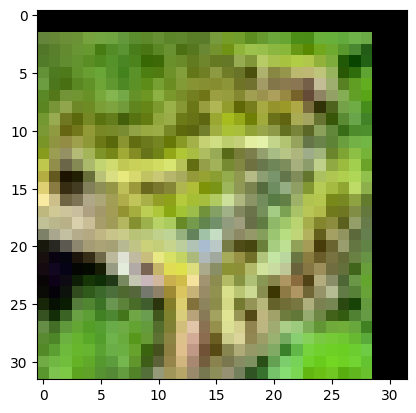

Label: frog


In [3]:
labels = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
std = [0.2023, 0.1994, 0.2010]
mean = [0.4914, 0.4822, 0.4465]
plt.imshow(((train_features[0].permute(1, 2, 0) * np.array(std) + np.array(mean))).numpy())
plt.show()
print(f"Label: {labels[train_labels[0]]}")

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
  """3x3 convolution with padding"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                   padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
  """1x1 convolution"""
  return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


In [5]:
# Define the VGG16 model
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Đảm bảo rằng đầu ra từ phần convolutional sẽ có kích thước (7x7x512)
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        #x = self.avgpool(x)  # Đảm bảo đầu ra có kích thước 7x7x512
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [6]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

    return test_loss / len(test_loader)

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    losses = []
    test_losses = []
    model.train()
    num_iter = 0
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            num_iter += 1
            if num_iter % 100 == 0:  # Print loss every 100 iterations
                print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{num_iter}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0
        num_iter = 0
        losses.append(running_loss / len(train_loader))
        test_loss = evaluate_model(model, test_loader, criterion)
        test_losses.append(test_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        print(f'Test Loss: {test_loss:.4f}')
    return losses, test_losses


In [7]:
# Initialize the model, loss function, and optimizer
model = VGG16()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
# Training the model
num_epochs = 50
losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# Evaluating the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the model on the 10,000 test images: {100 * correct / total:.2f}%')


Epoch [1/50], Iteration [100/782], Loss: 2.2535
Epoch [1/50], Iteration [200/782], Loss: 2.0024
Epoch [1/50], Iteration [300/782], Loss: 1.8874
Epoch [1/50], Iteration [400/782], Loss: 1.7948
Epoch [1/50], Iteration [500/782], Loss: 1.7506
Epoch [1/50], Iteration [600/782], Loss: 1.6736
Epoch [1/50], Iteration [700/782], Loss: 1.6312
Epoch [1/50], Loss: 0.1681
Test Loss: 1.5153
Epoch [2/50], Iteration [100/782], Loss: 1.5073
Epoch [2/50], Iteration [200/782], Loss: 1.4517
Epoch [2/50], Iteration [300/782], Loss: 1.4360
Epoch [2/50], Iteration [400/782], Loss: 1.3676
Epoch [2/50], Iteration [500/782], Loss: 1.3358
Epoch [2/50], Iteration [600/782], Loss: 1.2933
Epoch [2/50], Iteration [700/782], Loss: 1.2922
Epoch [2/50], Loss: 0.1326
Test Loss: 1.2276
Epoch [3/50], Iteration [100/782], Loss: 1.2404
Epoch [3/50], Iteration [200/782], Loss: 1.2059
Epoch [3/50], Iteration [300/782], Loss: 1.2009
Epoch [3/50], Iteration [400/782], Loss: 1.1828
Epoch [3/50], Iteration [500/782], Loss: 1.148

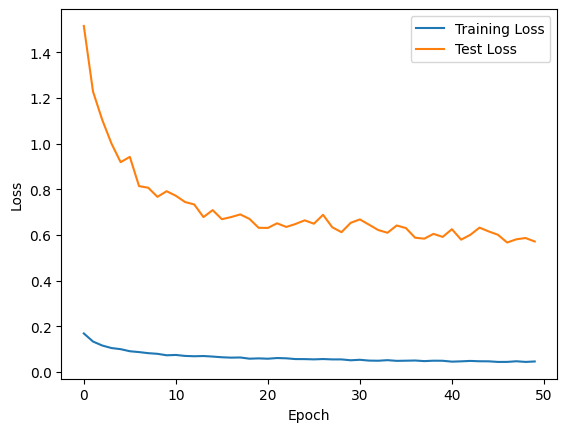

In [9]:
plt.plot(losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()